In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
module_path = os.path.join(os.environ['HOME'],'tools','a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind
import assessment.studies.coupling_comparison.helpers as helper

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT coupling comparison: Data analysis (template)

Simulation name and directory, and name of virtual towers

In [6]:
simname = 'internal_bcc_wrf_sowfa' # This is output prefix
dpath = '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/'
tower_filter = 'probe[0-9]'

In [7]:
tpathlist = glob.glob(os.path.join(dpath,tower_filter))
tpathlist.sort()
tpathlist

['/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe1',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe2',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe3',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe4',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe5',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe6',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe7',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe8',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe9']

Name of output files

In [8]:
output_tower0_10min   = os.path.join('./data',simname+'_tower0_10min.csv')
output_tower0_spectra = os.path.join('./data',simname+'_tower0_spectra.csv')
output_all_10min      = os.path.join('./data',simname+'_10min.csv')
output_all_spectra    = os.path.join('./data',simname+'_spectra.csv')

Heights and times at which spectra are computed. For each timestamp in `spectra_times`, the spectra will be computed for a period of `interval` starting at that timestamp with overlapping windows of size `window_size` (overlap of 50%). So with `interval = '1h'` and `window_size = '30min'`, each result will be the average of 3 overlapping windows.

In [9]:
spectra_heights = [10., 32., 80., 120.]
spectra_times = pd.date_range(start='2013-11-08 12:00:00',end='2013-11-09 11:00:00',freq='1h')
interval = '1h'
window_size = '30min'

Reference data 

In [10]:
#NetCDF file with WRF data at the SWiFT site generated in wrf_to_sowfa.ipynb, which can be found in
# a2e-mmc/assessment/studies/coupling_comparison/preprocessing/internal/
wrfdata = 'WRF_20131108-09.nc'

# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
towerdata_10min = 'TTU_tilt_corrected_20131108-09_10min.csv'
towerdata       = 'TTU_tilt_corrected_20131108-09.csv'

# Dataset generated in process_TTU_radar.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
radardata = 'TTU_obs_QC_20131108.csv'

# Part 1: Load, process and plot single virtual tower

## 1. Load virtual tower data

### 1a. Code-specific data loader

<font size=4><font color="red">**Define code-specific reader that returns a standardized pandas dataframe:**</font></font>

- multi-index dataframe with index levels `datetime` and `height`
- time axis is a `pd.DatetimeIndex`
- standard column names `u`, `v`, `w`, and `theta`
- standard SI units of [m], [m/s], and [K]

For example: use [NWTC/datatools/SOWFA6/postProcessing](https://github.com/NWTC/datatools/tree/master/SOWFA6/postProcessing) for reading in SOWFA output data

In [11]:
# manually add NWTC/datatools repo to PYTHONPATH
module_path = os.path.join(os.environ['HOME'],'tools')
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
from datatools.SOWFA6.postProcessing.probes import Probe

In [13]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!! SOWFA specific data reader, implement your own data reader as needed !!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def reader(tpath):
    # Read in virtual tower data and convert to pandas DataFrame
    df = Probe(tpath,verbose=False).to_pandas()
    
    # Convert time in seconds to datetime
    df.reset_index(inplace=True)
    df['t'] = pd.to_timedelta(df['t'],unit='s') + pd.to_datetime('2013-11-08 00:00')
    
    # Rename columns
    df.columns = ['datetime', 'height', 'u', 'v', 'w', 'theta']
    
    # Set multi-index with levels datetime and height
    df.set_index(['datetime','height'],inplace=True)
    return df

### 1b. Load data

In [14]:
%time df = reader(tpathlist[0])
df.head()
# CPU times: user 1min 42s, sys: 17.8 s, total: 2min
# Wall time: 2min 1s

CPU times: user 1min 42s, sys: 17.8 s, total: 2min
Wall time: 2min 1s


u         v         w       theta
datetime                height                                          
2013-11-08 12:00:00.500 5.001   2.008210  2.768477 -0.000150  283.252131
                        15.001  3.134927  4.237099 -0.000704  284.117924
                        25.001  3.945880  5.257111 -0.001438  284.845928
                        35.001  4.632506  6.121256 -0.002288  285.584276
                        45.001  5.284873  6.977440 -0.003207  286.363396

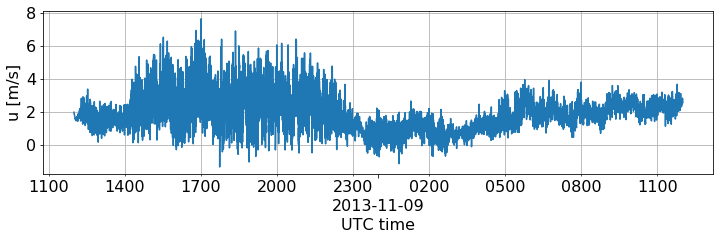

In [15]:
fig, ax = plot_timehistory_at_height(
    df,
    fields='u',
    heights = df.index.levels[1][0]
)

## 2. Data processing

### 2a. 10-min statistics

In [16]:
%time df_10min = helper.calc_stats(df)
# CPU times: user 9.44 s, sys: 4.06 s, total: 13.5 s
# Wall time: 13.5 s

CPU times: user 9.44 s, sys: 4.06 s, total: 13.5 s
Wall time: 13.5 s


In [17]:
helper.calc_QOIs(df_10min)

In [18]:
df_10min.head()

u         v         w       theta  \
datetime            height                                             
2013-11-08 12:00:00 5.001   1.680257  2.271912  0.001054  282.907679   
                    15.001  3.034235  4.340832  0.002532  284.015850   
                    25.001  3.990332  5.424120  0.000381  284.690796   
                    35.001  4.931860  6.362004 -0.008005  285.484187   
                    45.001  6.216764  7.330863 -0.004169  286.301082   

                                  uu        vv        ww        uv        vw  \
datetime            height                                                     
2013-11-08 12:00:00 5.001   0.014277  0.036897  0.000054  0.019851 -0.000330   
                    15.001  0.029048  0.011777  0.000895  0.008518  0.000772   
                    25.001  0.028712  0.021125  0.004479  0.008668 -0.002460   
                    35.001  0.077456  0.025837  0.009530  0.018822 -0.003934   
                    45.001  0.166550  0.029751  0.011219  0.038966 -0.002269   

                                  uw    thetaw      wspd        wdir  \
datetime            height                                             
2013-11-08 12:00:00 5.001  -0.000141 -0.000110  2.825748  216.485827   
                    15.001  0.000410 -0.000506  5.296169  214.953489   
                    25.001 -0.002907 -0.002395  6.733783  216.340590   
                    35.001 -0.008370 -0.001819  8.049742  217.783032   
                    45.001  0.000943 -0.003808  9.611956  220.298817   

                                  u*       TKE        TI  
datetime            height                                
2013-11-08 12:00:00 5.001   0.018928  0.025614  0.077436  
                    15.001  0.029568  0.020860  0.030119  
                    25.001  0.061711  0.027158  0.026592  
                    35.001  0.096170  0.056411  0.031290  
                    45.001  0.049571  0.103760  0.036844

In [19]:
%time df_10min.to_csv(output_tower0_10min)
# CPU times: user 740 ms, sys: 12 ms, total: 752 ms
# Wall time: 788 ms

CPU times: user 740 ms, sys: 12 ms, total: 752 ms
Wall time: 788 ms


### 2b. Turbulence spectra

In [20]:
# Compute windspeed and direction
df['wspd'], df['wdir'] = calc_wind(df)

In [21]:
# Interpolate to desired heights
%time df_hgt = helper.interpolate_to_heights(df,spectra_heights)
# CPU times: user 22.1 s, sys: 10.7 s, total: 32.8 s
# Wall time: 32.9 s

CPU times: user 22.1 s, sys: 10.7 s, total: 32.8 s
Wall time: 32.9 s


In [22]:
# Make sure data is equally spaced in time
%time df_hgt = helper.reindex_if_needed(df_hgt)
# CPU times: user 417 ms, sys: 1.83 ms, total: 419 ms
# Wall time: 419 ms

CPU times: user 417 ms, sys: 1.83 ms, total: 419 ms
Wall time: 419 ms


In [23]:
# Compute spectra
%time df_spectra = helper.calc_spectra(df_hgt,spectra_times,spectra_heights,interval,window_size)
df_spectra.head()
# CPU times: user 2.87 s, sys: 9.46 ms, total: 2.88 s
# Wall time: 2.89 s

CPU times: user 2.87 s, sys: 9.46 ms, total: 2.88 s
Wall time: 2.89 s


u         v         w     theta  \
datetime            height frequency                                           
2013-11-08 12:00:00 10.0   0.000000   1.807164  0.928544  0.059158  2.017122   
                           0.000556   9.497117  4.976299  0.146140  7.253449   
                           0.001111   4.980287  5.072441  0.101288  3.373896   
                           0.001667   1.488720  2.431627  0.197119  0.893901   
                           0.002222   2.846409  4.900414  0.075537  1.452124   

                                           wspd        wdir  
datetime            height frequency                         
2013-11-08 12:00:00 10.0   0.000000    1.051998  507.278906  
                           0.000556   10.228055  999.585788  
                           0.001111    9.206182  182.199183  
                           0.001667    3.256823  174.137924  
                           0.002222    6.720440  266.852209

In [24]:
%time df_spectra.to_csv(output_tower0_spectra)
# CPU times: user 2.01 s, sys: 24.7 ms, total: 2.03 s
# Wall time: 2.1 s

CPU times: user 2.01 s, sys: 24.7 ms, total: 2.03 s
Wall time: 2.1 s


## 3. Reference data

In [25]:
wrf = helper.load_wrf_reference_data(wrfdata)

In [26]:
radar_scan0, radar_scan1 = helper.load_radar_reference_data(radardata)

In [27]:
%%time
tower_10min = helper.load_tower_reference_data(towerdata_10min)
tower_spectra = helper.load_tower_reference_spectra(towerdata,
                                                    spectra_times,spectra_heights,
                                                    interval,window_size)
# CPU times: user 13 s, sys: 724 ms, total: 13.7 s
# Wall time: 13.7 s

CPU times: user 13 s, sys: 724 ms, total: 13.7 s
Wall time: 13.7 s


## 4. Plot virtual tower data

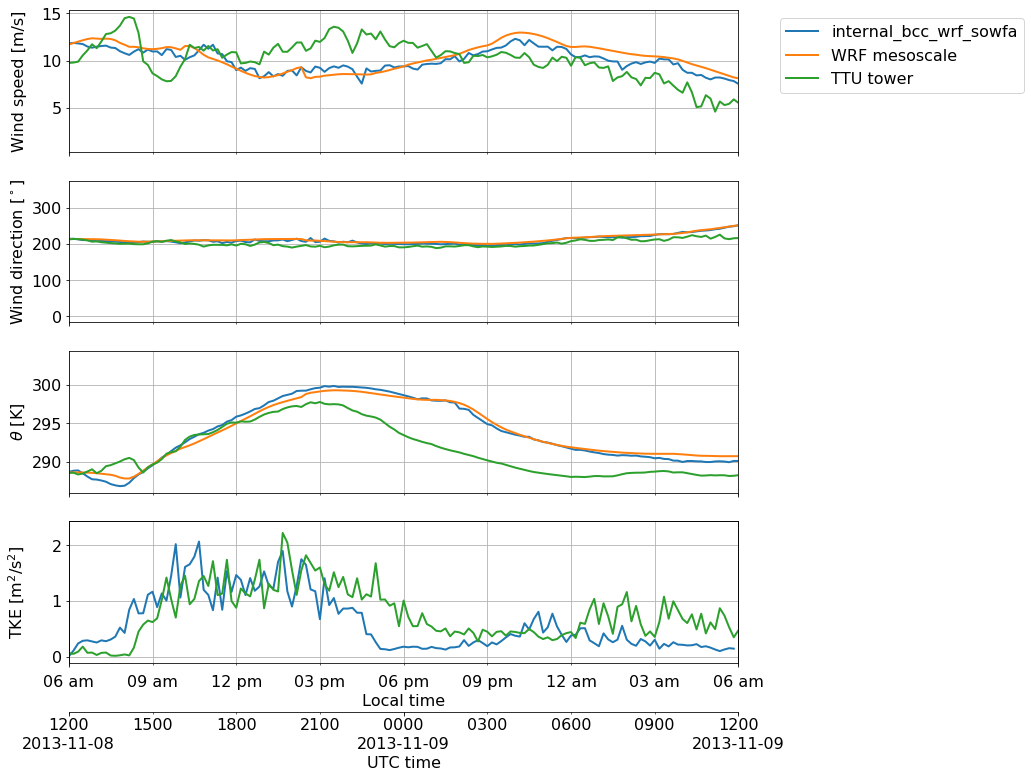

In [28]:
fig,ax,ax2 = plot_timehistory_at_height(
    datasets={simname:df_10min,'WRF mesoscale':wrf,'TTU tower':tower_10min},
    fields = ['wspd','wdir','theta','TKE'],
    heights = 80,
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    plot_local_time=True,
    local_time_offset=-6,
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

In [29]:
df_1h = df_10min.unstack().resample('1h').mean().stack()
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
wrf_1h = wrf.unstack().resample('1h').mean().stack()

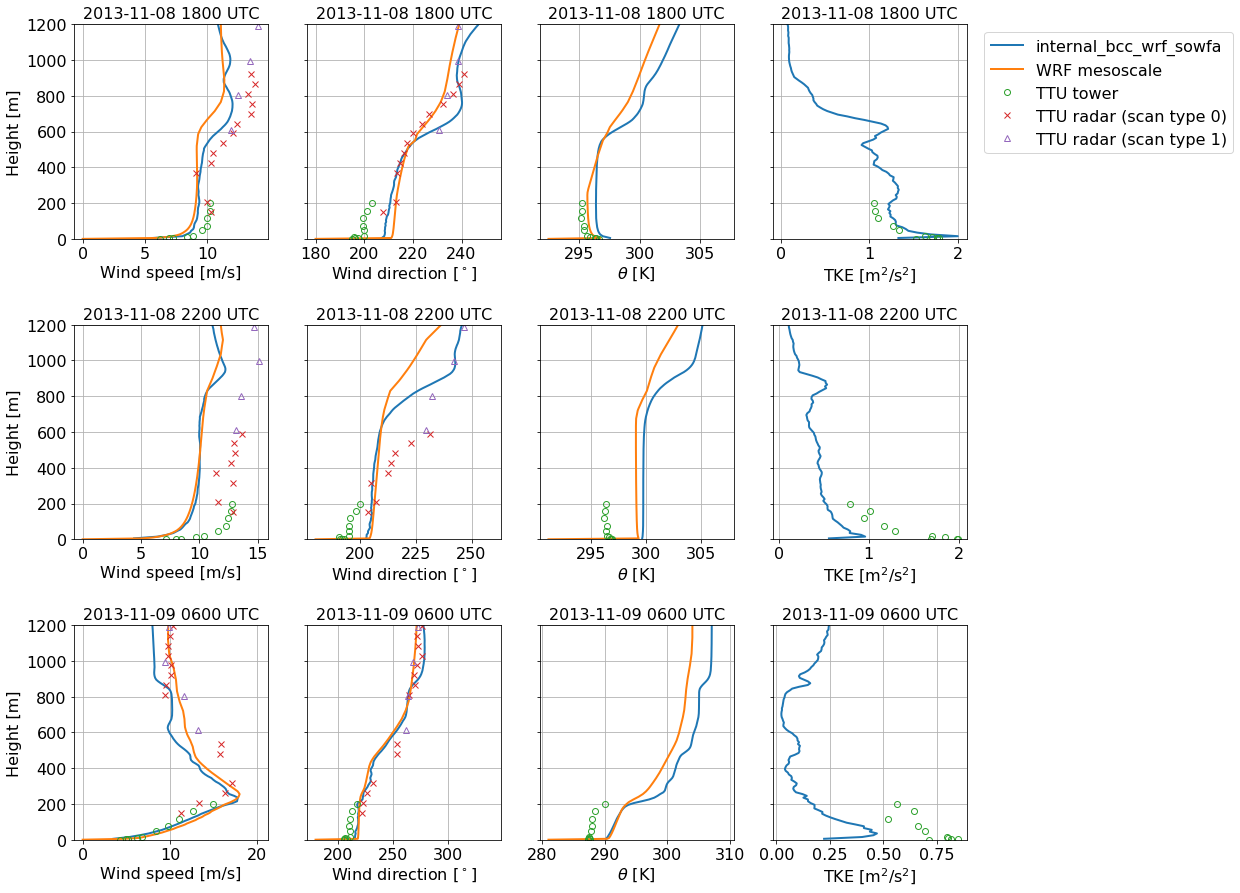

In [30]:
fig,ax = plot_profile(
    datasets={simname:df_1h,
              'WRF mesoscale':wrf_1h,
              'TTU tower':tower_1h,
              'TTU radar (scan type 0)':radar_scan0_1h,
              'TTU radar (scan type 1)':radar_scan1_1h},
    fields=['wspd','wdir','theta','TKE'],
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    # Specify height limits
    heightlimits=(0,1200),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x','mfc':'none','markersize':6},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'^','mfc':'none','markersize':6}
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
)

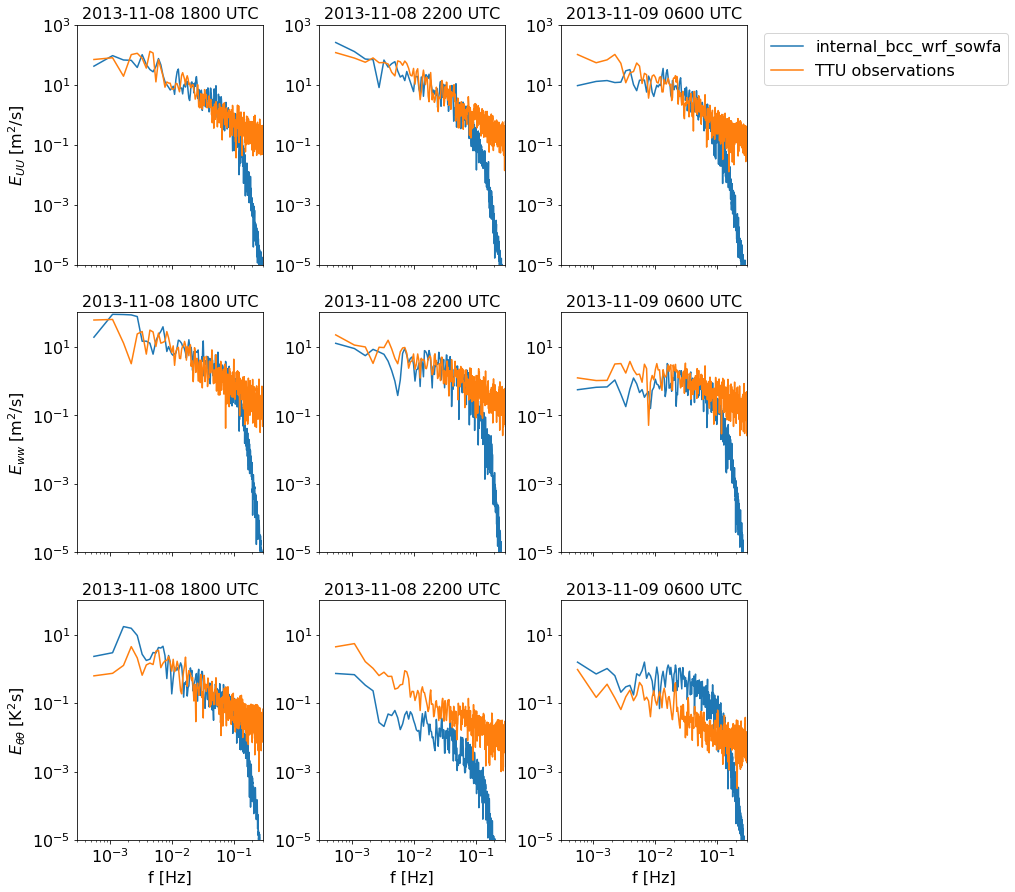

In [31]:
fig,ax = plot_spectrum(
    datasets={simname:df_spectra,'TTU observations':tower_spectra},
    height=80,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    fields=['wspd','w','theta'],
    freqlimits=(0.0003,0.3),
    fieldlimits={'wspd':(1.0e-5,1.0e3),'w':(1.0e-5,1.0e2),'theta':(1.0e-5,1.0e2)},
)

# Part 2: Load, process, average and save all virtual tower data

In [32]:
%%time
df_10min = []
df_spectra = []
for towerID, tpath in enumerate(tpathlist):
    print('Reading '+tpath)
    try:
        # 1. Read tower
        dfi = reader(tpath)
        
        # 2. Calculate statistics
        dfi_10min = helper.calc_stats(dfi)
        dfi_10min['towerID'] = towerID
        
        # 3. Calculate spectra
        # - compute wspd and wdir so that corresponding spectra are calculated as well
        dfi['wspd'],dfi['wdir'] = calc_wind(dfi)
        # - interpolate to specific heights
        dfi_hgt = helper.interpolate_to_heights(dfi,spectra_heights)
        # - reindex if some timestamps are missing
        dfi_hgt = helper.reindex_if_needed(dfi_hgt)
        # - calculate spectra at specific times
        dfi_spectra = helper.calc_spectra(dfi_hgt,spectra_times,spectra_heights,interval,window_size)
        dfi_spectra['towerID'] = towerID
    except (IOError, UnicodeDecodeError, AssertionError, ValueError) as err:
        print(err,'while reading',tpath)
    
    # Append to list
    df_10min.append(dfi_10min)
    df_spectra.append(dfi_spectra)
    
df_10min = pd.concat(df_10min)
df_10min.set_index('towerID',append=True,inplace=True)

df_spectra = pd.concat(df_spectra)
df_spectra.set_index('towerID',append=True,inplace=True)

# CPU times: user 20min 31s, sys: 3min 2s, total: 23min 34s
# Wall time: 23min 48s

Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe1
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe2
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe3
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe4
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe5
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe6
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe7
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe8
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe9
CPU times: user 20min 31s, sys: 3min 2s, total: 23min 34s
Wall time: 23min 48s


In [33]:
df_10min.head(n=10)

u          v         w       theta  \
datetime            height towerID                                              
2013-11-08 12:00:00 5.001  0        1.680257   2.271912  0.001054  282.907679   
                    15.001 0        3.034235   4.340832  0.002532  284.015850   
                    25.001 0        3.990332   5.424120  0.000381  284.690796   
                    35.001 0        4.931860   6.362004 -0.008005  285.484187   
                    45.001 0        6.216764   7.330863 -0.004169  286.301082   
                    55.001 0        5.734964   7.989761  0.011908  287.220448   
                    65.001 0        6.241696   8.433769  0.001220  287.895892   
                    75.001 0        6.743363   9.356230 -0.007434  288.428609   
                    85.001 0        6.772118  10.055776 -0.001811  288.868600   
                    95.001 0        7.152389  10.738132  0.002970  289.253524   

                                          uu        vv        ww        uv  \
datetime            height towerID                                           
2013-11-08 12:00:00 5.001  0        0.014277  0.036897  0.000054  0.019851   
                    15.001 0        0.029048  0.011777  0.000895  0.008518   
                    25.001 0        0.028712  0.021125  0.004479  0.008668   
                    35.001 0        0.077456  0.025837  0.009530  0.018822   
                    45.001 0        0.166550  0.029751  0.011219  0.038966   
                    55.001 0        0.035899  0.014398  0.010549 -0.002272   
                    65.001 0        0.006710  0.014114  0.001503  0.004525   
                    75.001 0        0.009618  0.003061  0.002325  0.003119   
                    85.001 0        0.002186  0.009394  0.004689  0.002121   
                    95.001 0        0.038488  0.024174  0.001699  0.028611   

                                          vw        uw    thetaw  
datetime            height towerID                                
2013-11-08 12:00:00 5.001  0       -0.000330 -0.000141 -0.000110  
                    15.001 0        0.000772  0.000410 -0.000506  
                    25.001 0       -0.002460 -0.002907 -0.002395  
                    35.001 0       -0.003934 -0.008370 -0.001819  
                    45.001 0       -0.002269  0.000943 -0.003808  
                    55.001 0        0.000157 -0.001609  0.001026  
                    65.001 0       -0.000538 -0.000533  0.000789  
                    75.001 0       -0.000017 -0.000017 -0.001129  
                    85.001 0       -0.000058  0.000524 -0.000218  
                    95.001 0        0.000015  0.000147  0.000229

In [34]:
df_spectra.head(n=10)

u          v         w  \
datetime            height frequency towerID                                  
2013-11-08 12:00:00 10.0   0.000000  0        1.807164   0.928544  0.059158   
                           0.000556  0        9.497117   4.976299  0.146140   
                           0.001111  0        4.980287   5.072441  0.101288   
                           0.001667  0        1.488720   2.431627  0.197119   
                           0.002222  0        2.846409   4.900414  0.075537   
                           0.002778  0        5.973215   7.587177  0.108439   
                           0.003333  0        6.079305   6.402854  0.329724   
                           0.003889  0        6.141630  10.625006  0.155563   
                           0.004444  0        6.773565  14.277783  0.271647   
                           0.005000  0        6.027575  15.005357  0.655824   

                                                 theta       wspd        wdir  
datetime            height frequency towerID                                   
2013-11-08 12:00:00 10.0   0.000000  0        2.017122   1.051998  507.278906  
                           0.000556  0        7.253449  10.228055  999.585788  
                           0.001111  0        3.373896   9.206182  182.199183  
                           0.001667  0        0.893901   3.256823  174.137924  
                           0.002222  0        1.452124   6.720440  266.852209  
                           0.002778  0        1.744971  12.610439  190.595120  
                           0.003333  0        0.845908  10.638430  200.012832  
                           0.003889  0        0.721974  15.804093  216.296464  
                           0.004444  0        1.233867  20.162291  298.851019  
                           0.005000  0        0.882342  19.610816  355.845671

Average over all the towers

In [35]:
df_10min = df_10min.unstack(level=['datetime','height']).mean(axis=0).unstack(level=0)

In [36]:
%time df_10min.to_csv(output_all_10min)
# CPU times: user 537 ms, sys: 7.96 ms, total: 545 ms
# Wall time: 576 ms

CPU times: user 537 ms, sys: 7.96 ms, total: 545 ms
Wall time: 576 ms


In [37]:
df_spectra = df_spectra.unstack(level=['datetime','height','frequency']).mean(axis=0).unstack(level=0)

In [38]:
%time df_spectra.to_csv(output_all_spectra)
# CPU times: user 2.05 s, sys: 29 ms, total: 2.08 s
# Wall time: 2.16 s

CPU times: user 2.05 s, sys: 29 ms, total: 2.08 s
Wall time: 2.16 s
